Problem was with FFTLog mode. 'SLOW' works better.

Populating the interactive namespace from numpy and matplotlib


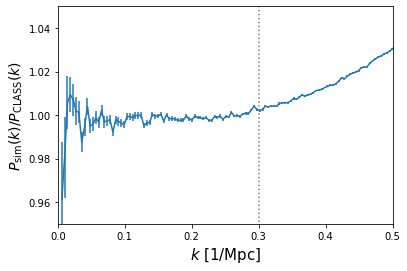

In [29]:
from classy import Class
from scipy.optimize import minimize
%pylab inline

cosmol = Class()
z = 3.
Omega_c = (0.3175-0.049)
Omega_b = 0.049
h = 0.6711
A_s = 2.134724e-09
n_s = 0.9624
N_eff = 3.046

# Set class parameters
cosmol.set({'k_pivot':'0.05',
        'A_s':A_s,
        'n_s':n_s,
        'h':h,
        'Omega_b':Omega_b,
        'N_eff':N_eff,
        'Omega_cdm':Omega_c,
        'P_k_max_h/Mpc': '300.',
        'output':'mPk,tCl,lCl',
        'z_pk':z,
        'non linear':' PT ',
        'IR resummation':' Yes ',
        'Bias tracers':' No ',
        'RSD':' No ',
        #'AP':'Yes',
        'FFTLog mode':'SLOW',
        'Omfid':Omega_c+Omega_b
        })
# Compute CLASS and set nuisance parameters
cosmol.compute()

## Load all Quijote fiducial high resolution power spectra and convert units
all_quijote_pk = np.load('/home/ophilcox/quijote_fid_HR_all_Pk.npy')
kQ = all_quijote_pk[0,0,:]*h

PkQ = all_quijote_pk[:,-1,:]/h**3. # at z = 3

### Generate Pk
pk_mult = cosmol.get_pk_mult(kQ,z,len(kQ))

one_loop_pk = lambda cs: (pk_mult[14] + pk_mult[0] + 2*cs*pk_mult[10])
lin_pk = [cosmol.pk_lin(kk,z) for kk in kQ]

### Fit to data
k_max = 0.3
chi2 = lambda cs: np.sum(((one_loop_pk(cs)-PkQ.mean(axis=0))**2./(PkQ.std(axis=0)/np.sqrt(len(PkQ)))**2.)[kQ<k_max])

x = minimize(chi2,1.)
cs_opt = x.x

plt.errorbar(kQ,PkQ.mean(axis=0)/one_loop_pk(cs_opt),yerr=PkQ.std(axis=0)/np.sqrt(len(PkQ))/one_loop_pk(cs_opt))
plt.xlim([0,0.5])
plt.ylim([0.95,1.05])
plt.ylabel(r'$P_\mathrm{sim}(k)/P_\mathrm{CLASS}(k)$',fontsize=14)
plt.xlabel(r'$k$ [1/Mpc]',fontsize=15);
plt.vlines(k_max,0,2,linestyles=':',color='gray');